# K-means Clustering with Pyspark

In [103]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType, TimestampType, LongType, DoubleType
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col 
from pyspark.sql import functions as F
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from pyspark.sql.functions import when, col, isnan

In [61]:
spark = SparkSession.builder.master('local[*]').appName("K-means with file").config('spark.ui.port','4050').getOrCreate()

In [62]:
file_path = "/home/gc100/Downloads/part-00000-318611a1-7cdc-4dd0-9348-c6368917fd0c-c000.csv"
df = spark.read.csv(file_path, header = True, inferSchema = True)

In [63]:
df.count()

10260

### Find the name of the attacks

In [64]:
tactics_names = df.select("mitre_attack_tactics").distinct().collect()
tactics_names

[Row(mitre_attack_tactics='none'), Row(mitre_attack_tactics='Reconnaissance')]

### Create a new column of Features with each row containing a vector that has all numeric values of this entire row

In [65]:
columns_to_check = ["resp_pkts", "orig_ip_bytes","missed_bytes", "duration", "orig_pkts", 
                    "resp_ip_bytes", "dest_port","orig_bytes", "resp_bytes", 
                    "src_port", "ts"]
#df_cleaned = df.na.drop(subset=columns_to_check) #Removes rows that have any missing values in the specified columns
#assembler = VectorAssembler(
#    inputCols = columns_to_check,
#    outputCol = "features",
#    handleInvalid = "skip" 
#)
#df_assembler = assembler.transform(df) 
df_filled = df.na.fill(0, subset=columns_to_check)
assembler = VectorAssembler(
    inputCols = columns_to_check,
    outputCol = "features"
)
df_assembled = assembler.transform(df_filled)

<h3> Scale all the features into a new column called scaledFeatures.</h3> <br> <p> Standard Scalar gets each point and subtracts it by the mean and divides it by the std. <br> <p> z = (x-μ)/σ​

In [66]:
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)
df_scaled.select("features", "scaledFeatures").limit(5).toPandas()

,features,scaledFeatures
0,"(0.0, 240.0, 0.0, 0.0010759830474853516, 4.0, ...","(0.0, 2.5599590803402803, 0.0, 0.0003256528110..."
1,"(0.0, 240.0, 0.0, 0.0010759830474853516, 4.0, ...","(0.0, 2.5599590803402803, 0.0, 0.0003256528110..."
2,"(0.0, 240.0, 0.0, 0.0010759830474853516, 4.0, ...","(0.0, 2.5599590803402803, 0.0, 0.0003256528110..."
3,"(0.0, 240.0, 0.0, 0.0010759830474853516, 4.0, ...","(0.0, 2.5599590803402803, 0.0, 0.0003256528110..."
4,"(0.0, 240.0, 0.0, 0.0010759830474853516, 4.0, ...","(0.0, 2.5599590803402803, 0.0, 0.0003256528110..."


### Apply the K-means algorithm on the scaled features

In [84]:
kmeans = KMeans(featuresCol= "scaledFeatures", k=3, seed=20) 
model = kmeans.fit(df_scaled)

<h3>With this settings, the algorithm was able to separate clusters that contained just attacks</h3>
<p> -k=9 and seed=20 for first file 
    <br> "/home/gc100/Downloads/part-00000-0af89d10-df53-44fd-b124-a8a496fd5023-c000.csv"
<p> -k=3 and seed=20 for second
    <br> "/home/gc100/Downloads/part-00000-318611a1-7cdc-4dd0-9348-c6368917fd0c-c000.csv"
<p> -k=25 and seed=20 for third
    <br> "/home/gc100/Downloads/part-00000-15e3dd03-ea76-429e-a52a-ce96a90517f9-c000.csv"

In [85]:
centers = model.clusterCenters()
df_pred = model.transform(df_scaled)

In [86]:
df_pred = df_pred.withColumnRenamed("prediction", "cluster")

### Find the clusters that contain attacks

In [87]:
clusters_w_attacks = df_pred.select("cluster").where("mitre_attack_tactics = 'Reconnaissance'").distinct().collect()
#clusters_w_attacks
clusters_w_attacks = [row.cluster for row in clusters_w_attacks]
clusters_w_attacks

[1]

<h3>See how many normal data we have in each cluster that contain attacks</h3>
<p>If 0 is found then the algorithm works and we were able to have clusters cointaining exclusively attacks</p>

In [88]:
for cluster in clusters_w_attacks:
    count = df_pred.select("cluster").where((df_pred["mitre_attack_tactics"] == 'none') & (df_pred["cluster"] == cluster)).count()
    print(f"Cluster: {cluster}, Count: {count}")

Cluster: 1, Count: 0


<h3>Check if these clusters actually contain the attacks and how many points are present on each cluster</h3>

In [89]:
for cluster in clusters_w_attacks:
    count = df_pred.select("cluster").where((df_pred["mitre_attack_tactics"] == 'Reconnaissance') & (df_pred["cluster"] == cluster)).count()
    print(f"Cluster: {cluster}, Count: {count}")

Cluster: 1, Count: 2048


In [90]:
df_pred.select("mitre_attack_tactics", "cluster").where("mitre_attack_tactics = 'Reconnaissance'").show(5)

+--------------------+-------+
|mitre_attack_tactics|cluster|
+--------------------+-------+
|      Reconnaissance|      1|
|      Reconnaissance|      1|
|      Reconnaissance|      1|
|      Reconnaissance|      1|
|      Reconnaissance|      1|
+--------------------+-------+
only showing top 5 rows



In [91]:
#for center in centers:
    #print(center)

### Check how many points we have on each cluster

In [92]:
df_pred.groupBy("cluster").count().orderBy("cluster").show(10)

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 7767|
|      1| 2048|
|      2|  445|
+-------+-----+



### Label all the attacks as 1

In [93]:
df_pred = df_pred.withColumn(
    'label',
    when(col('mitre_attack_tactics').isin('Reconnaissance', 'Discovery'), 1).otherwise(0)
)

# Show the result to verify
df_pred.select('mitre_attack_tactics', 'label').show(5)

+--------------------+-----+
|mitre_attack_tactics|label|
+--------------------+-----+
|      Reconnaissance|    1|
|      Reconnaissance|    1|
|      Reconnaissance|    1|
|      Reconnaissance|    1|
|      Reconnaissance|    1|
+--------------------+-----+
only showing top 5 rows



### Label all the points that are on the clusters with attacks as 1

In [94]:
df_pred = df_pred.withColumn(
    'prediction',
    when(col('cluster').isin(clusters_w_attacks), 1).otherwise(0)
)

# Show the result to verify
df_pred.select('mitre_attack_tactics', 'prediction').show(5)

+--------------------+----------+
|mitre_attack_tactics|prediction|
+--------------------+----------+
|      Reconnaissance|         1|
|      Reconnaissance|         1|
|      Reconnaissance|         1|
|      Reconnaissance|         1|
|      Reconnaissance|         1|
+--------------------+----------+
only showing top 5 rows



### Compare this two columns and calculate the Confusion Matrix, Precision, and Recall

In [95]:
df_pred = df_pred.withColumn('label', col('label').cast(IntegerType()))
    
pred_and_labels = df_pred.select('prediction', 'label').collect()
    
pred_and_labels = [(row['prediction'], row['label']) for row in pred_and_labels]
    
predictions, labels = zip(*pred_and_labels)
    
conf_matrix = confusion_matrix(labels, predictions)

precision = precision_score(labels, predictions, average='weighted')
recall = recall_score(labels, predictions, average='weighted')
accuracy = accuracy_score(labels, predictions)
    
print("Confusion Matrix:")
print(conf_matrix)
    
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

Confusion Matrix:
[[8212    0]
 [   0 2048]]
Precision: 1.0
Recall: 1.0
Accuracy: 1.0


## Plot to see how the clusters look like

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA #Principal Component Analysis for dimensionality reduction

In [97]:
data = df_pred.select("scaledFeatures","cluster").collect()

In [98]:
features = np.array([row['scaledFeatures'] for row in data])
predictions = np.array([row['cluster'] for row in data])

In [99]:
pca = PCA(n_components = 2)
components = pca.fit_transform(features.tolist())

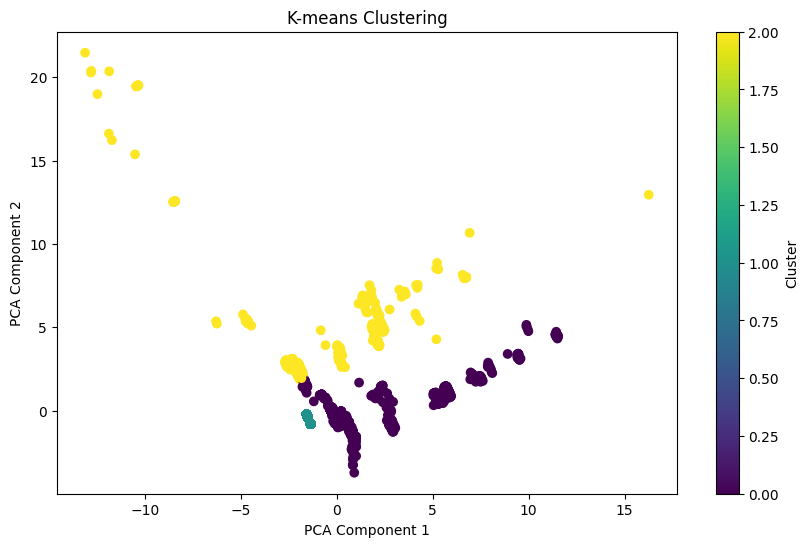

In [100]:
plt.figure(figsize=(10,6))
plt.scatter(components[:,0], components[:,1], c=predictions, cmap='viridis', marker='o')
plt.title('K-means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label = 'Cluster')
plt.show()

## Graph that shows where the attacks where

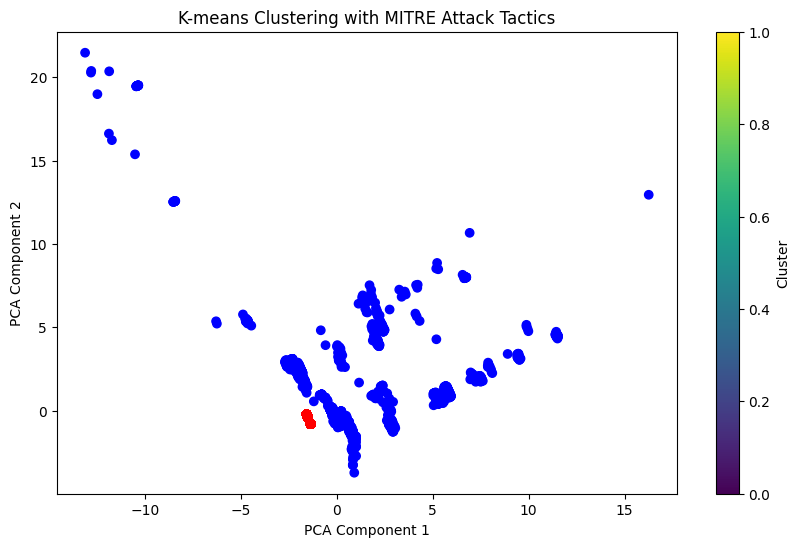

In [101]:
data = df_pred.select("scaledFeatures", "cluster", "mitre_attack_tactics").collect()
features = np.array([row['scaledFeatures'] for row in data])
predictions = np.array([row['cluster'] for row in data])
tactics = np.array([row['mitre_attack_tactics'] for row in data])
color_map = {
    'Reconnaissance': 'red',
    'none': 'blue'
}
colors = [color_map.get(tactic, 'gray') for tactic in tactics]

# Plotting the PCA components
plt.figure(figsize=(10, 6))
plt.scatter(components[:, 0], components[:, 1], c=colors, marker='o')
plt.title('K-means Clustering with MITRE Attack Tactics')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [102]:
spark

In [532]:
spark.sparkContext.stop()